# Fitting distribution of workplace size

This is an exercise on fitting real, in this case the distribution of company sizes in Denmark (in terms of FTE workers). This distribution was used in relation to Covid-19 modelling, but is in itself interresting.

You only need to consider the first two columns (size and frequency), as the rest is just derived from there.

NOTE: When extracting data from Statistics Denmark (DK: Danmarks Statistik), bins with less than 5 entries are by law not allowed to be revealed (to protect from ability to single out persons/companies), and are shown as NaN (Not a Number).

### References
Data from Statistics Denmark (contact: Laust Hvas Mortensen)

### Authors
Troels C. Petersen (NBI, petersen@nbi.dk)

### Date
04-12-2023 (latest update)

***

In [1]:
from __future__ import division, print_function

import sys
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from iminuit import Minuit
from scipy import stats
import pandas as pd
from scipy import interpolate

sys.path.append('../../External_Functions')
from ExternalFunctions import UnbinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax

In [2]:
save_plots = False   # For now, don't save plots (once you trust your code, switch on)
verbose = True       # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10        # But only print a lot for the first 10 random numbers

### Load data

In [4]:
data_test = pd.read_csv("TableData_Denmark2020.txt", header=0, sep=' ', index_col=0)

print(data_test.head(10))
print("...")
print(data_test.tail(10))

# Two 1D arrays:
Nworkers = np.arange(1, 200)
Ncompanies = data_test["Frequency"].iloc[1:200].values  # "values" yields numpy arrays, while nothing gives a Pandas series
eNcompanies = np.sqrt(Ncompanies)         # NOT CORRECT - what uncertainty to assign here?

minPlot = 1
maxPlot = 100


        Frequency  Percent  Cumulative  Frequency.1  Cumulative.1  Percent.1
ANTNOV                                                                      
0         20696.0     9.29       20696         9.29           NaN        NaN
1         52418.0    23.52       73114        32.80           NaN        NaN
2         27431.0    12.31      100545        45.11           NaN        NaN
3         17242.0     7.74      117787        52.84           NaN        NaN
4         13090.0     5.87      130877        58.72           NaN        NaN
5         10325.0     4.63      141202        63.35           NaN        NaN
6          8465.0     3.80      149667        67.15           NaN        NaN
7          6891.0     3.09      156558        70.24           NaN        NaN
8          5841.0     2.62      162399        72.86           NaN        NaN
9          4816.0     2.16      167215        75.02           NaN        NaN
...
        Frequency  Percent  Cumulative  Frequency.1  Cumulative.1  Perce

### Plotting the size distribution of companies

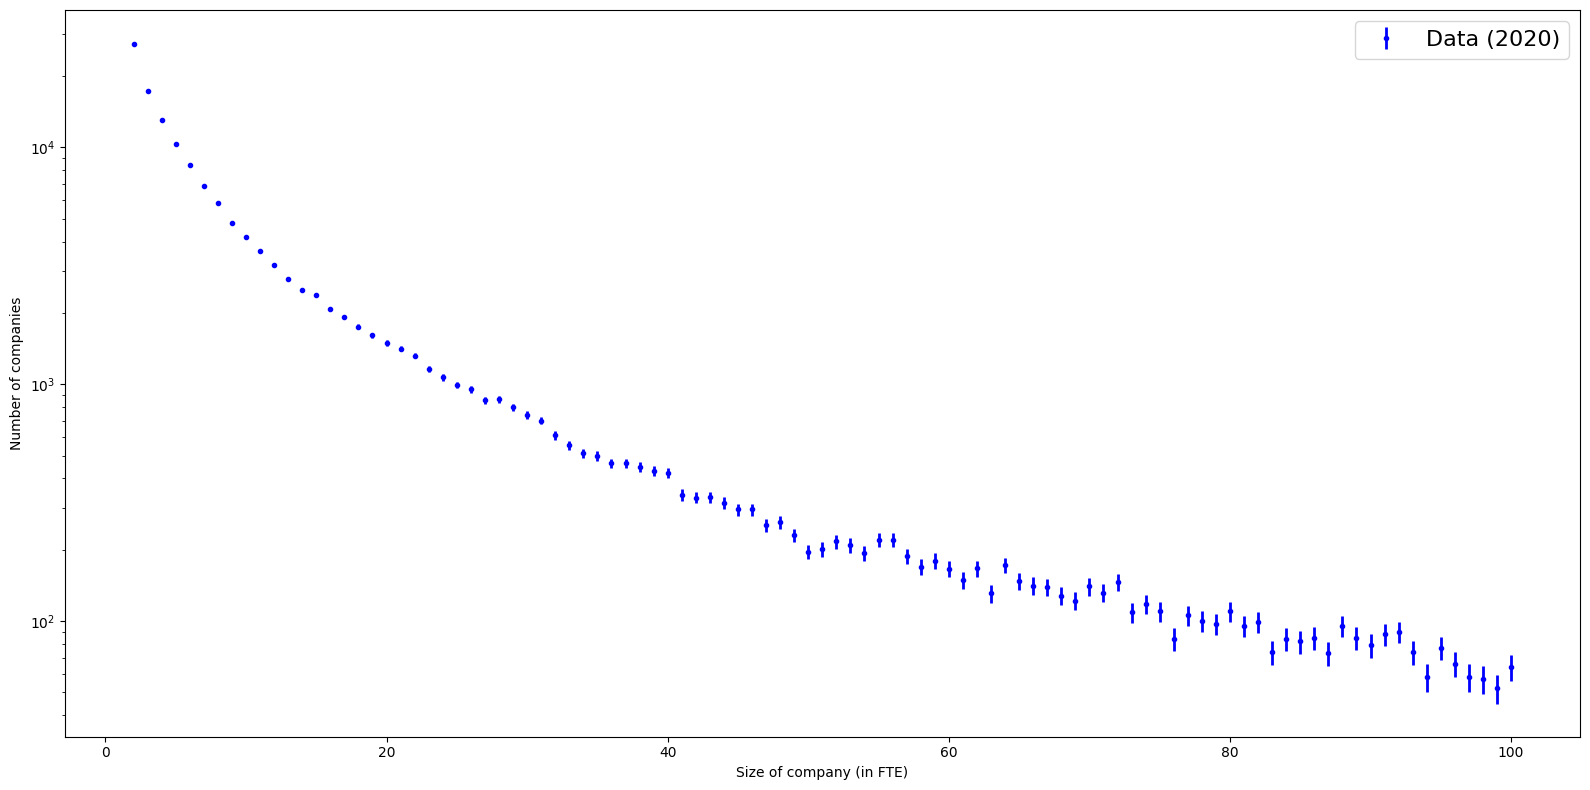

In [5]:
# Number of companies with a given size as a function of size:
fig_Ncompanies, ax_Ncompanies = plt.subplots(figsize=(16, 8))
ax_Ncompanies.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")
ax_Ncompanies.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                  label='Data (2020)', color='blue')
ax_Ncompanies.legend(fontsize=16) #loc=(0.05, 0.75))

plt.yscale('log')
plt.tight_layout()
plt.show(block=False)

if (save_plots):
    plt.savefig("fig_DistNcompanies.pdf")

## Models

What is the best model for this distribution? Try the below models, and make better alternatives yourself.

In [6]:
# Power Law model:
def func_PowerLaw(x, N, alpha):
    return N * x ** (-alpha)

func_PowerLaw_vec = np.vectorize(func_PowerLaw)

In [7]:
# Exponential model:
def func_Exponential(x, N, alpha):
    return N * np.exp(-alpha * x)

func_Exponential_vec = np.vectorize(func_Exponential)

In [12]:
# Exponential and power model:
def func_both(x, N1, alpha1, N2, alpha2):
    return N1 * np.exp(-alpha1 * x) + N2 * x ** (-alpha2)

func_both_vec = np.vectorize(func_both)

In [26]:
# custom model:
def func_custom(x, N1, alpha1, N2, alpha2, k):
    return N1 * np.exp(-alpha1 * x**k) + N2 * x ** (-alpha2)

func_custom_vec = np.vectorize(func_custom)

### Fit to data with Power Law


  ------------------------------------  Fitting Stage  --------------------------------------- 

Fit value (exp): N = 89687.68905 +/- 424.03596
Fit value (exp): alpha = 1.45003 +/- 0.00204
  Model fit:  Prob(Chi2=6644.7, Ndof=197) = 0.00000


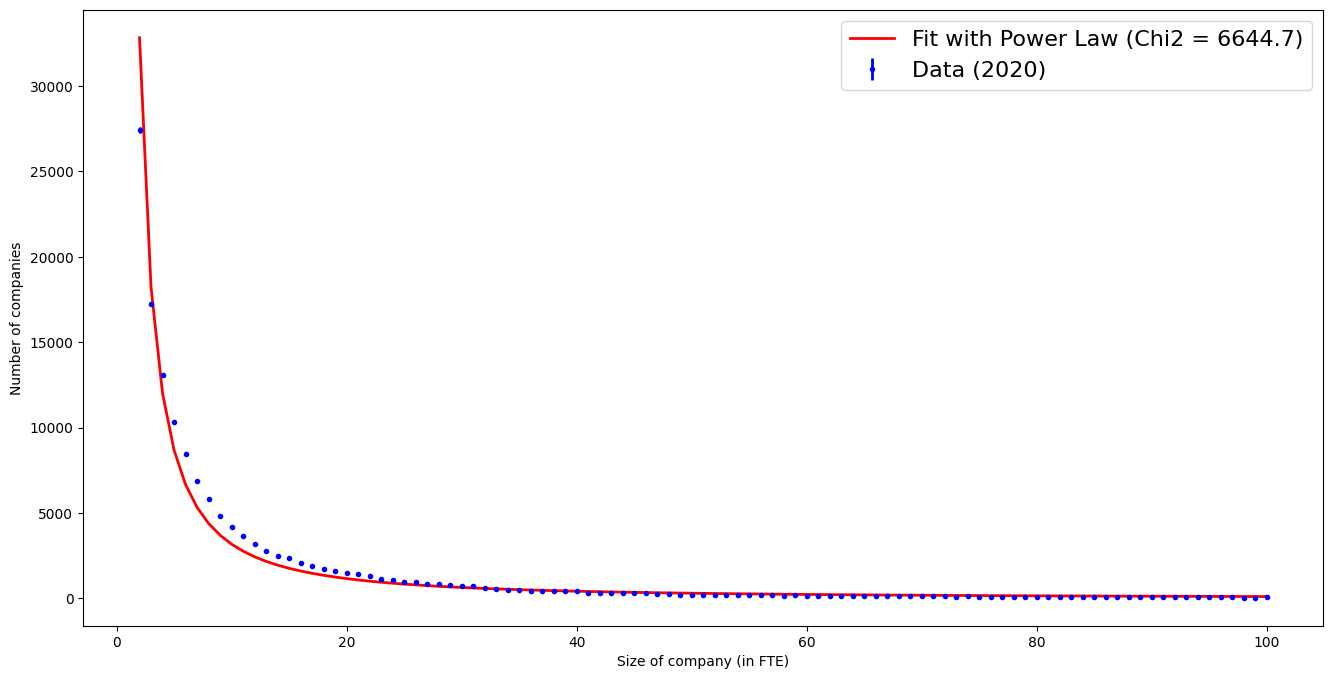

In [17]:
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

minFit = 1
maxFit = 100

# Plot data points again
fig_fit, ax_fit = plt.subplots(figsize=(16, 8))
ax_fit.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")


# Power Law fit:
# --------------
def ChiSquarePowerLaw(N, alpha):
    Ncompanies_est = func_PowerLaw(Nworkers[minFit:maxFit], N, alpha)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

minuit = Minuit(ChiSquarePowerLaw, N=50000.0, alpha=2.0)
minuit.errordef = 1.0   # Chi2 fit
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Ncompanies) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

N_fit, alpha_fit = minuit.values[:]
eN_fit, ealpha_fit = minuit.errors[:]
ax_fit.plot(Nworkers[minFit:maxFit], func_PowerLaw_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), 'red', linewidth=2.0,
            label=f'Fit with Power Law (Chi2 = {chi2:6.1f})')
ax_fit.legend(fontsize=16);

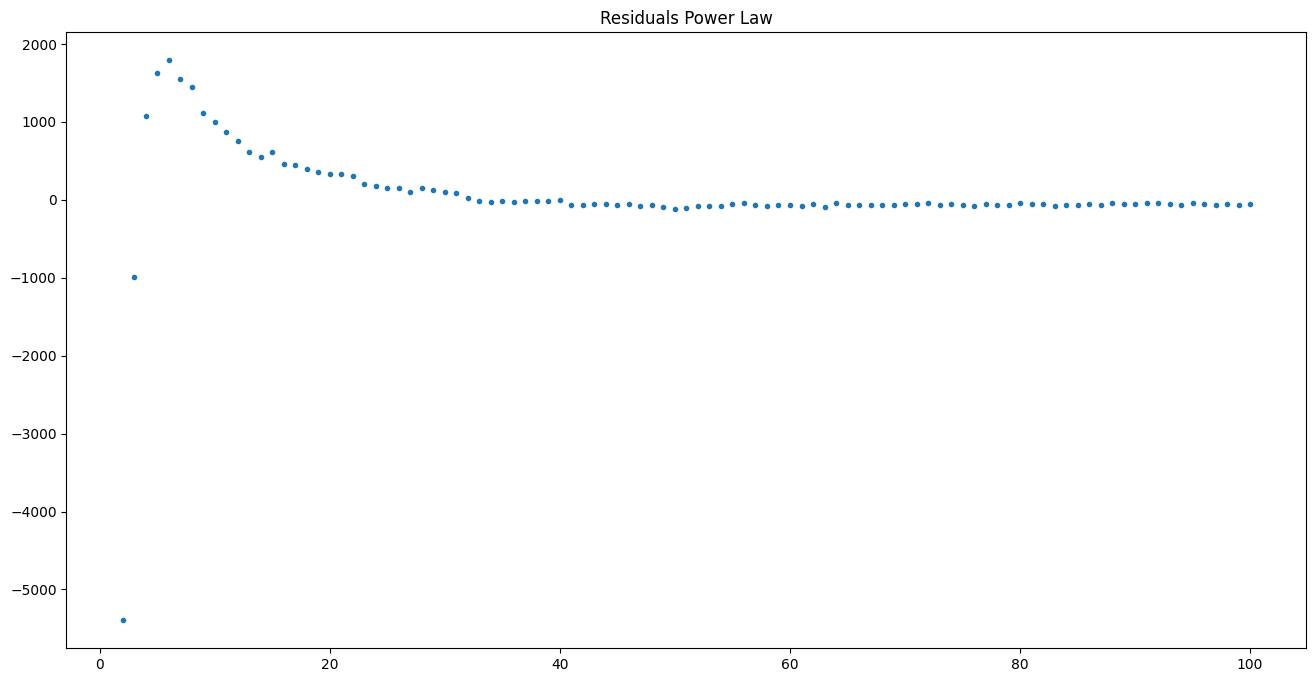

In [18]:
residuals_PowerLaw = Ncompanies[minPlot:maxPlot] - func_PowerLaw_vec(Nworkers[minPlot:maxPlot], N_fit, alpha_fit)
plt.figure(figsize=(16,8))
plt.title("Residuals Power Law")
plt.plot(Nworkers[minPlot:maxPlot], residuals_PowerLaw, '.')
plt.show()


  ------------------------------------  Fitting Stage  --------------------------------------- 

Fit value (exp): N = 20800.78478 +/- 145.98852
Fit value (exp): alpha = 0.13385 +/- 0.00072
  Model fit:  Prob(Chi2=18797.5, Ndof=197) = 0.00000


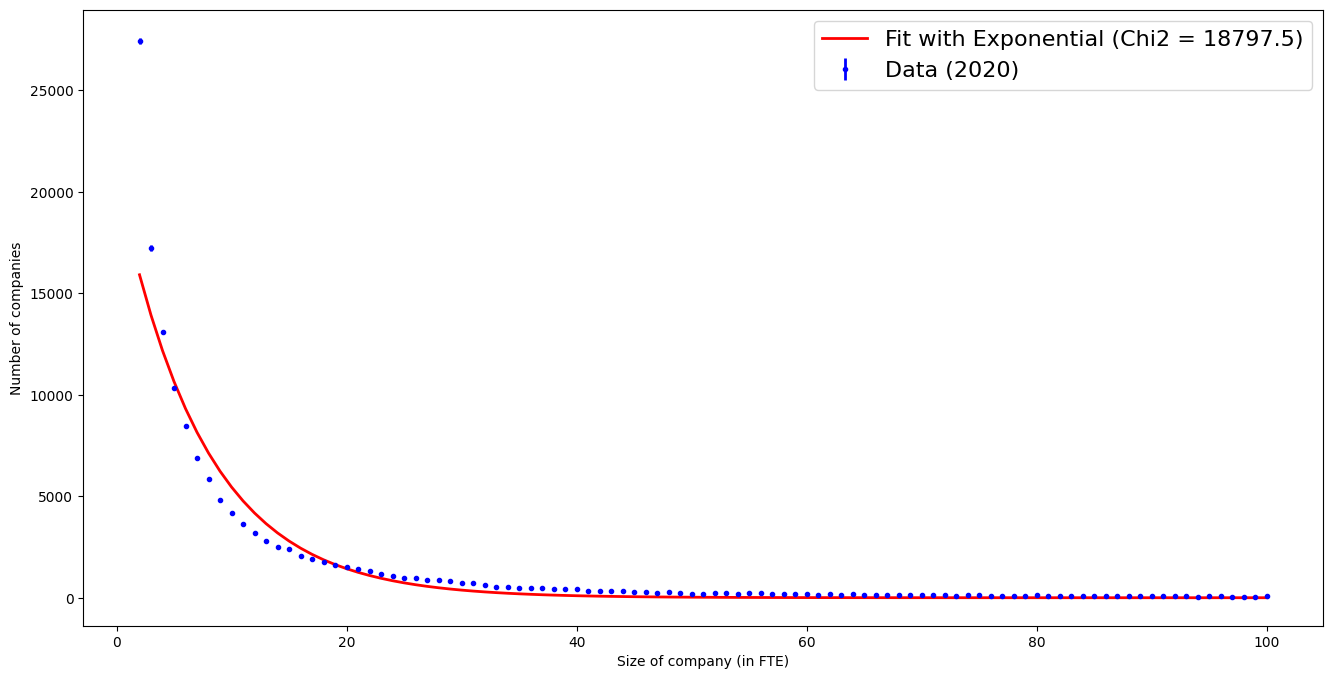

In [19]:
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

fig_fit, ax_fit = plt.subplots(figsize=(16, 8))
ax_fit.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")

def ChiSquareExponential(N, alpha):
    Ncompanies_est = func_Exponential(Nworkers[minFit:maxFit], N, alpha)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

minuit = Minuit(ChiSquareExponential, N=50000.0, alpha=2.0)
minuit.errordef = 1.0   # Chi2 fit
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Ncompanies) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

N_fit, alpha_fit = minuit.values[:]
eN_fit, ealpha_fit = minuit.errors[:]
ax_fit.plot(Nworkers[minFit:maxFit], func_Exponential_vec(Nworkers[minFit:maxFit], N_fit, alpha_fit), 'red', linewidth=2.0,
            label=f'Fit with Exponential (Chi2 = {chi2:6.1f})')
ax_fit.legend(fontsize=16);

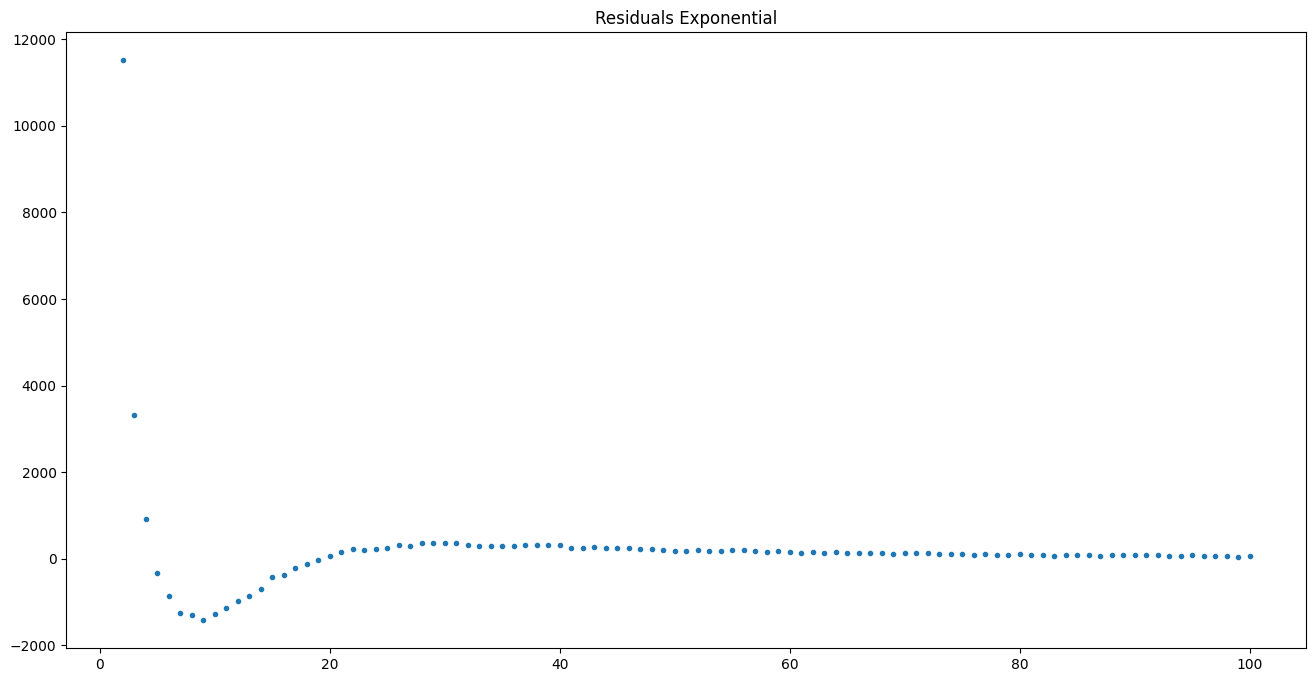

In [20]:
residuals_Exponential = Ncompanies[minPlot:maxPlot] - func_Exponential_vec(Nworkers[minPlot:maxPlot], N_fit, alpha_fit)
plt.figure(figsize=(16,8))
plt.title("Residuals Exponential")
plt.plot(Nworkers[minPlot:maxPlot], residuals_Exponential, '.')
plt.show()


  ------------------------------------  Fitting Stage  --------------------------------------- 

Fit value (exp): N1 = 6620.35178 +/- 141.96828
Fit value (exp): alpha1 = 0.11019 +/- 0.00145
Fit value (exp): N2 = 62909.19161 +/- 744.24884
Fit value (exp): alpha2 = 1.46685 +/- 0.00482
  Model fit:  Prob(Chi2= 373.6, Ndof=195) = 0.00000


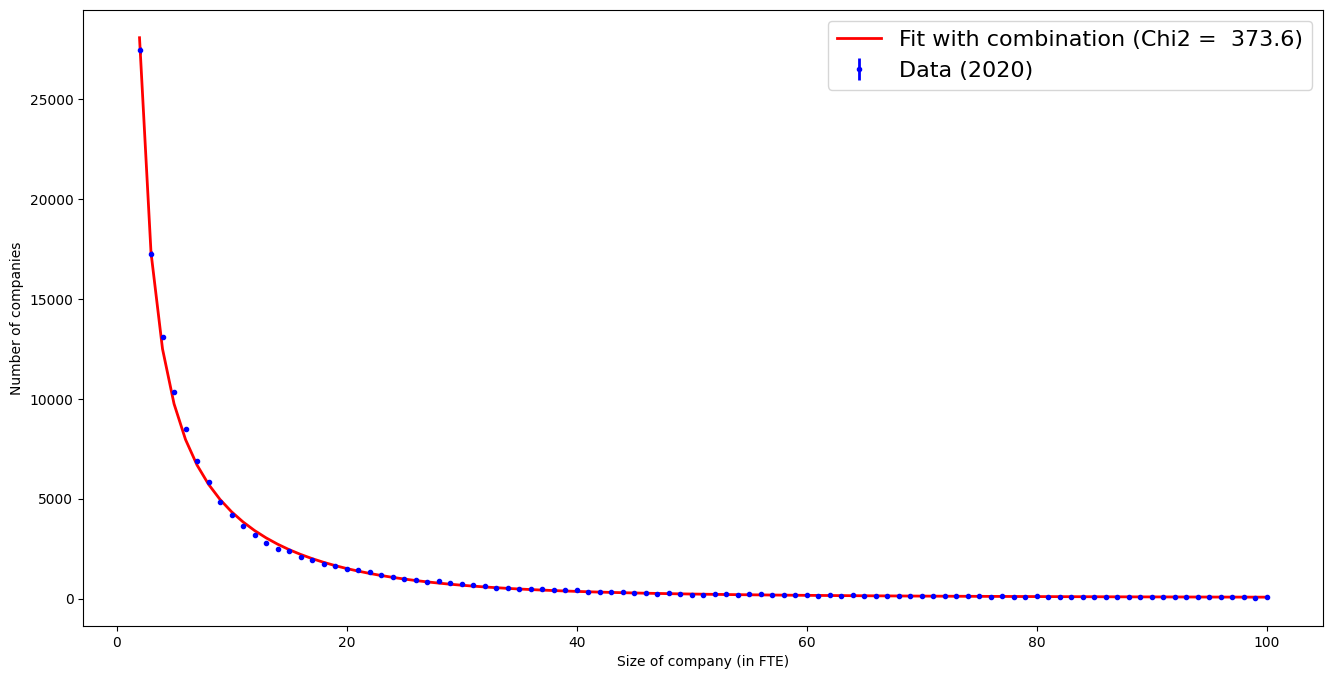

In [22]:
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

fig_fit, ax_fit = plt.subplots(figsize=(16, 8))
ax_fit.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")

def ChiSquareboth(N1, alpha1, N2, alpha2):
    Ncompanies_est = func_both(Nworkers[minFit:maxFit], N1, alpha1, N2, alpha2)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

minuit = Minuit(ChiSquareboth, N1=50000.0, alpha1=2.0, N2=50000.0, alpha2=2.0)
minuit.errordef = 1.0   # Chi2 fit
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Ncompanies) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

N1_fit, alpha1_fit, N2_fit, alpha2_fit = minuit.values[:]
eN1_fit, ealpha1_fit, eN2_fit, ealpha2_fit = minuit.errors[:]
ax_fit.plot(Nworkers[minFit:maxFit], func_both_vec(Nworkers[minFit:maxFit], N1_fit, alpha1_fit, N2_fit, alpha2_fit), 'red', linewidth=2.0,
            label=f'Fit with combination (Chi2 = {chi2:6.1f})')
ax_fit.legend(fontsize=16);

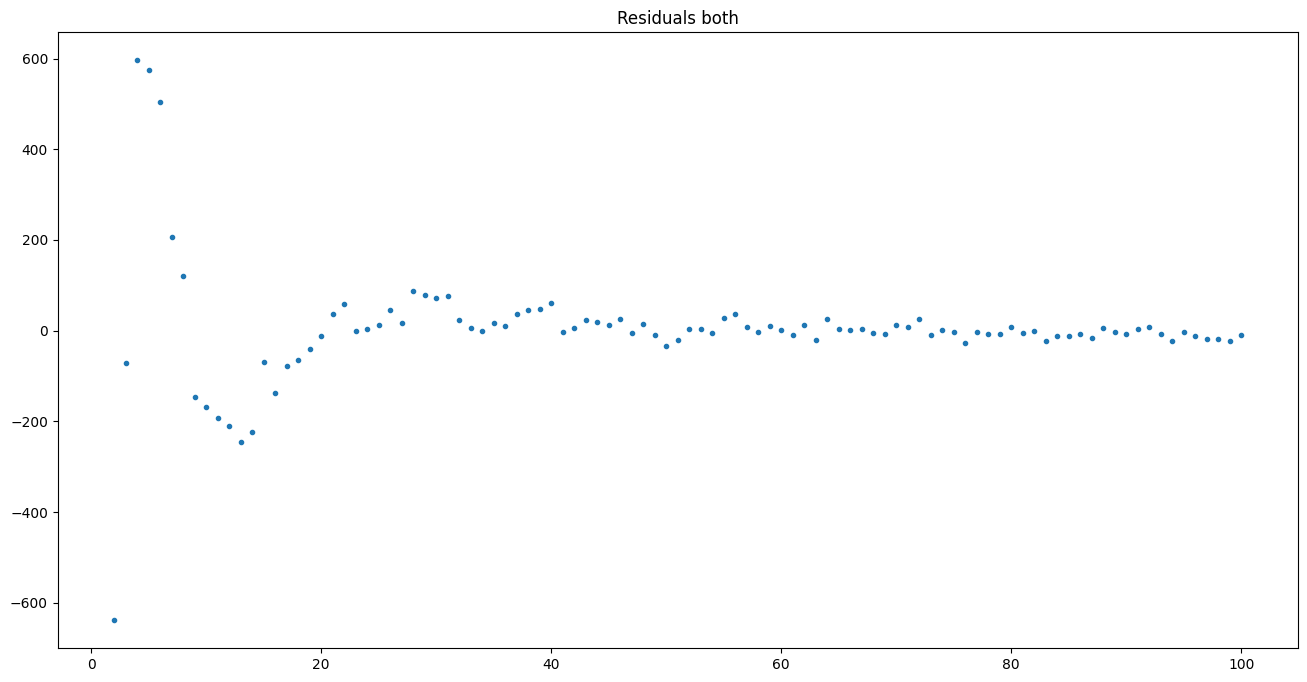

In [23]:
residuals_both = Ncompanies[minPlot:maxPlot] - func_both_vec(Nworkers[minPlot:maxPlot], N1_fit, alpha1_fit, N2_fit, alpha2_fit)
plt.figure(figsize=(16,8))
plt.title("Residuals both")
plt.plot(Nworkers[minPlot:maxPlot], residuals_both, '.')
plt.show()


  ------------------------------------  Fitting Stage  --------------------------------------- 

Fit value (exp): N1 = 38657.47371 +/- 5978.79742
Fit value (exp): alpha1 = 0.81573 +/- 0.08319
Fit value (exp): N2 = 41159.53155 +/- 2199.92349
Fit value (exp): alpha2 = 1.44191 +/- 0.01129
Fit value (exp): k = 0.50853 +/- 0.02226
  Model fit:  Prob(Chi2= 177.5, Ndof=194) = 0.79573


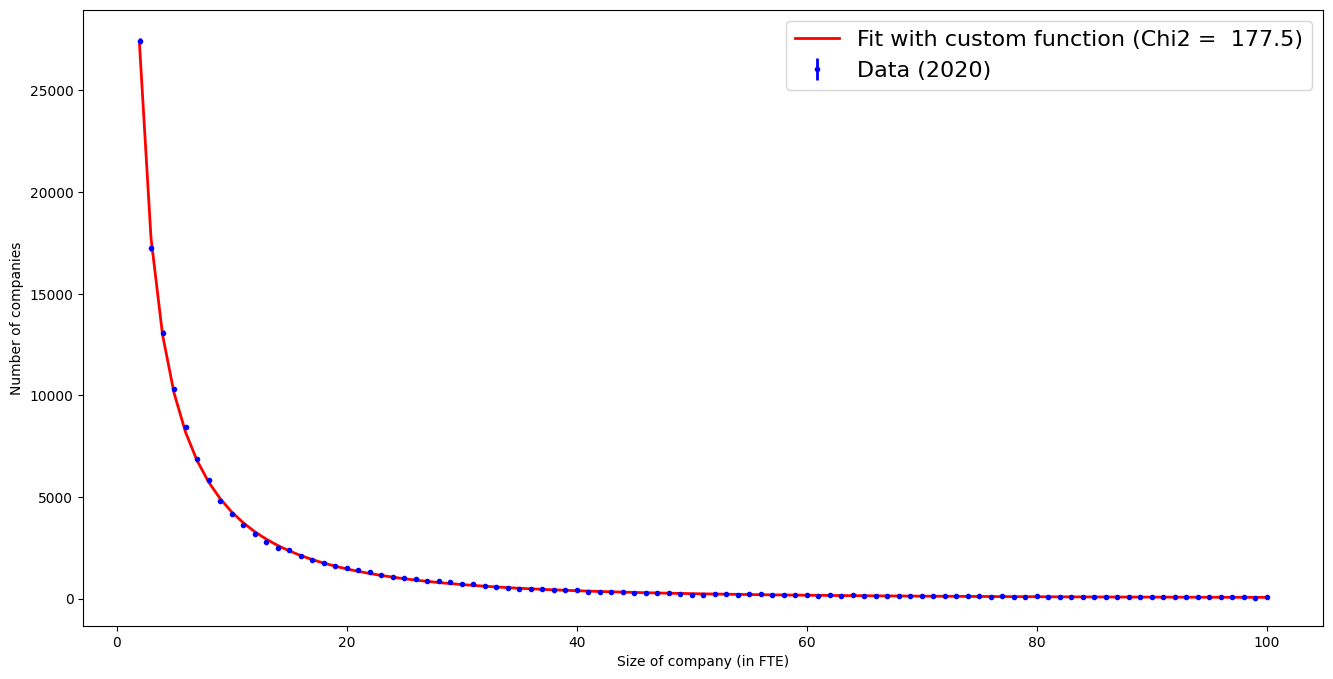

In [27]:
print("\n  ------------------------------------  Fitting Stage  --------------------------------------- \n")

fig_fit, ax_fit = plt.subplots(figsize=(16, 8))
ax_fit.errorbar(Nworkers[minPlot:maxPlot], Ncompanies[minPlot:maxPlot], yerr=eNcompanies[minPlot:maxPlot], fmt='.', linewidth=2,
                color="blue", label='Data (2020)')
ax_fit.set(xlabel="Size of company (in FTE)", ylabel="Number of companies", title="")

def ChiSquareCustom(N1, alpha1, N2, alpha2, k):
    Ncompanies_est = func_custom(Nworkers[minFit:maxFit], N1, alpha1, N2, alpha2, k)
    chi2 = np.sum(((Ncompanies[minFit:maxFit] - Ncompanies_est) / eNcompanies[minFit:maxFit]) ** 2)
    return chi2

minuit = Minuit(ChiSquareCustom, N1=50000.0, alpha1=2.0, N2=50000.0, alpha2=2.0, k=1.0)
minuit.errordef = 1.0   # Chi2 fit
minuit.migrad();
if (not minuit.fmin.is_valid):
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")

for name in minuit.parameters:
    print("Fit value (exp): {0} = {1:.5f} +/- {2:.5f}".format(name, minuit.values[name], minuit.errors[name]))
chi2 = minuit.fmin.fval
Ndof = len(Ncompanies) - len(minuit.values[:])
Prob = stats.chi2.sf(chi2, Ndof)
print(f"  Model fit:  Prob(Chi2={chi2:6.1f}, Ndof={Ndof:3d}) = {Prob:7.5f}")

N1_fit, alpha1_fit, N2_fit, alpha2_fit, k_fit = minuit.values[:]
eN1_fit, ealpha1_fit, eN2_fit, ealpha2_fit, ek_fit = minuit.errors[:]
ax_fit.plot(Nworkers[minFit:maxFit], func_custom_vec(Nworkers[minFit:maxFit], N1_fit, alpha1_fit, N2_fit, alpha2_fit, k_fit), 'red', linewidth=2.0,
            label=f'Fit with custom function (Chi2 = {chi2:6.1f})')
ax_fit.legend(fontsize=16);

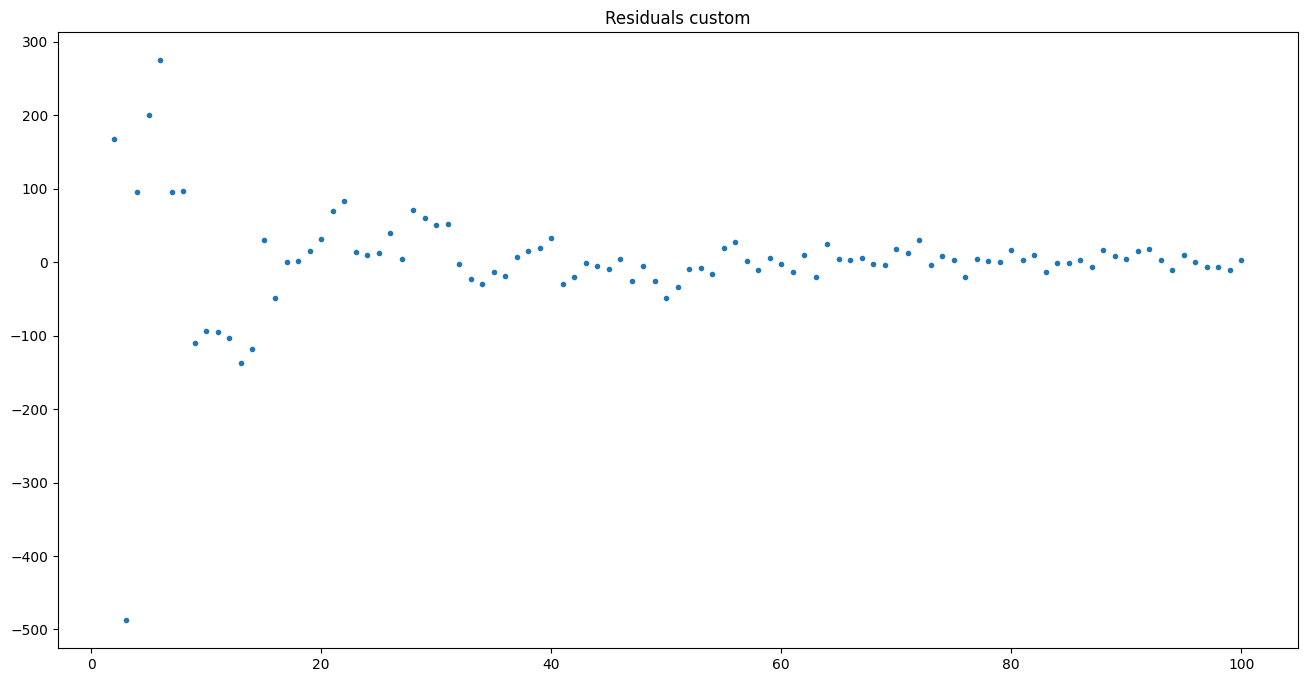

In [28]:
residuals_custom = Ncompanies[minPlot:maxPlot] - func_custom_vec(Nworkers[minPlot:maxPlot], N1_fit, alpha1_fit, N2_fit, alpha2_fit, k_fit)
plt.figure(figsize=(16,8))
plt.title("Residuals custom")
plt.plot(Nworkers[minPlot:maxPlot], residuals_custom, '.')
plt.show()

In [42]:
N_companies_range_true = Ncompanies[100:149].sum()
N_companies_range_est = func_custom_vec(Nworkers[100:149], N1_fit, alpha1_fit, N2_fit, alpha2_fit, k_fit).sum()
N_rel_dev = (N_companies_range_est-N_companies_range_true)/N_companies_range_true * 100
print(f"We estimate that there are {N_companies_range_est} in the range 101-150. \n The true value is {N_companies_range_true}. \n Relative deviation {N_rel_dev:2.2f}%")

We estimate that there are 2121.008179106266 in the range 101-150. 
 The true value is 1839.0. 
 Relative deviation 15.33%


In [ ]:
if (save_plots):
    plt.savefig("fig_NworkersInDKcompanies_Fit.pdf")

# Questions

1. Try to fit the data (in the range 1-100) with a power law, an exponential, and a combination of the two. Are you satisfied with the results? Perhaps include a new plot of the residuals (i.e. data - fit) below the one showing the fit itself.

No, the fits are pretty bad, they all have a low p-value, although the combination is better.

2. Can you think of any other function that would fit throught the data better? Try to expand on the functions by adding more complexity and parameters, and see how well you can do. Do you manage to reach a "good" model, and how would you define one such?

I reached a model with a p-value of around 0.7, which is quite high, so I would say it is a good model.


3. From a "good" fit, try to predict how many companies there are with 101-150 employes. Compare this number to the data, and see how well you manage.

We manage to do this with a relative error of around 15%, which is not too bad.

# Learning points:

From this exercise you should become capable of fitting data (in histogram) with many different (possibly similar) models, and evaluate their performance. From the last question, you should also become capable of extrapolating to obtain an estimate of the number of larger companies.